<a href="https://colab.research.google.com/github/chandank21/Electrical-Household-Load-Forecasting/blob/main/Load_Forecasting_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from  sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import explained_variance_score,mean_squared_error,mean_absolute_percentage_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from keras.models import load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_data(file_dir):
    data = pd.read_csv(file_dir,sep=';',
                    header=0,low_memory=False,
                    infer_datetime_format=True,
                    parse_dates={'datetime':[0,1]},
                    index_col=['datetime'])
    return data

def clean_data(data):
  data.replace('?',np.NaN,inplace=True)
  data = data.fillna(method='bfill')
  data = data.astype('float32')
  return data

def remove_outlier(data):
  data_reindexed = data.reset_index(drop=False)
  deviation = (data_reindexed.Global_intensity.values*2) - data_reindexed.Global_intensity.shift(1) - data_reindexed.Global_intensity.shift(-1)
  deviation_index = data_reindexed[abs(deviation) > 10].index

  for index in deviation_index:
    for cols in data.columns:
        data_reindexed.loc[index,cols] = np.mean((data_reindexed.loc[index-1,cols],data_reindexed.loc[index,cols],data_reindexed.loc[index+1,cols]))

  # adding original index...
  data = data_reindexed.set_index(data_reindexed['datetime'])
  data = data.drop(['datetime'],axis=1)
  return data

def scaling_data(data):
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(data)
  return scaled,scaler

def series_to_supervised(df_as_np,n_lags,n_out=1):
  X,y = [],[]
  for i in range(len(df_as_np)-n_lags):
    row = [ a for a in df_as_np[i:i+n_lags]]
    X.append(row)
    label = df_as_np[i+n_lags:i+n_lags+n_out,0]
    y.append(label)
  return np.array(X), np.array(y)

In [16]:
dataset = load_data(r'/content/drive/MyDrive/datasets/household_power_consumption.txt')

In [46]:
# Useful columns...
cols=['Global_active_power', 'Global_reactive_power', 'Global_intensity']

# useful data..
dataset = dataset[cols]

#cleaning data and filling mising values..
clean_data = clean_data(dataset)

# removing outliers....
outlier_removed_data = remove_outlier(clean_data)

# resampling data based on hour...
data_hourly = outlier_removed_data.resample('H').mean()

# scaling data based on minmaxscaler or standard scaler...
data_as_np,scaler = scaling_data(dataset)

# no pf back step...
n_lags=120
n_out=1
 # converting data into deep neural network format...
input,target = series_to_supervised(data_as_np,n_lags,n_out)
input , target = input[500:],target[500:]
train_input = input[:23000]
test_input = input[26000:]
validation_input = input[23000:26000]
train_target = target[:23000]
test_target = target[26000:]
validation_target = target[23000:26000]
train_input.shape,test_input.shape,train_target.shape,test_target.shape

((23000, 120, 3), (7969, 120, 3), (23000, 1), (7969, 1))

COLLEGE DATA

In [13]:
env_data = pd.read_csv(r'/content/drive/MyDrive/datasets/Env_load_data.csv')
env_data.rename(columns = {' (kW)':'active_power'}, inplace = True)
env_data = env_data.set_index(env_data['datetime'])[['active_power']]
env_data.drop(env_data.tail(1).index,inplace=True)
env_data.index = pd.to_datetime(env_data.index)

UK DATA

In [28]:
UK_data = pd.read_csv(r'/content/drive/MyDrive/datasets/House_1.csv')
UK_data=UK_data.set_index(UK_data['Time'])[['Aggregate']]
UK_data.index = pd.to_datetime(UK_data.index)

(array([6.822399e+06, 1.142610e+05, 2.496000e+03, 1.825000e+04,
        2.436000e+03, 3.100000e+01, 2.600000e+01, 4.100000e+01,
        6.500000e+01, 3.000000e+00]),
 array([    0. ,  2915.9,  5831.8,  8747.7, 11663.6, 14579.5, 17495.4,
        20411.3, 23327.2, 26243.1, 29159. ]),
 <a list of 10 Patch objects>)

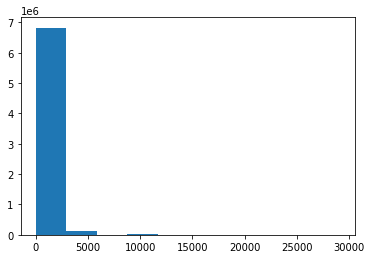

In [29]:
plt.hist(UK_data.Aggregate.values)

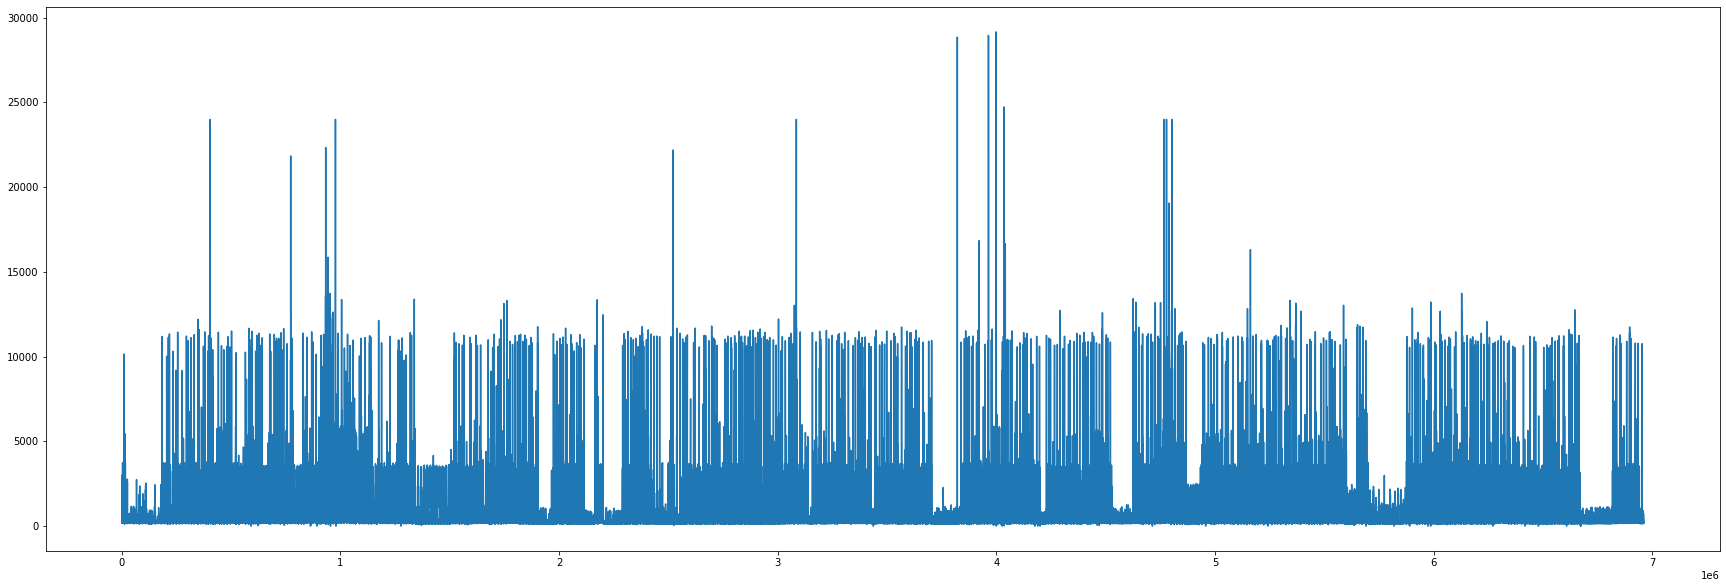

In [30]:
plt.figure(figsize=(30,10))
plt.plot(UK_data.Aggregate.values)

In [ ]:
time_index = pd.date_range(start='2013-10-09 14:00:00',end='2015-07-10 10:59:59',freq='1H')
active_power = []
for i in range(len(time_index)):
  hour_df=UK_data.loc[time_index[i]:time_index[i+1]]
  value = hour_df.Aggregate.values
  total=0
  for j in range(len(hour_df.index)-1):
    total+=(hour_df.index[j+1]-hour_df.index[j]).total_seconds()*value[j]
  total+=value[-1]
  active_power.append((total/3600))

UK_houly_data = pd.DataFrame({'active_power':active_power},index=time_index)

In [31]:
# resampling data based on hour...
#data_hourly = UK_data.resample('1H').mean()

# scaling data based on minmaxscaler or standard scaler...
data_as_np,scaler = scaling_data(data_hourly)

# no pf back step...
n_lags=24
n_out=1
 # converting data into deep neural network format...
input,target = series_to_supervised(data_as_np,n_lags,n_out)
n_train = int(0.7*data_hourly.shape[0])
train_input = input[:n_train]
test_input = input[n_train:]
train_target = target[:n_train]
test_target = target[n_train:]
train_input.shape,test_input.shape,train_target.shape,test_target.shape

((10734, 24, 1), (4577, 24, 1), (10734, 1), (4577, 1))

In [ ]:
#date_index=new_data.index.to_series()
#new_data['year']=date_index.dt.year
#new_data['month']=date_index.dt.month
#new_data['day_of_week']=date_index.dt.dayofweek
#new_data['hour']=date_index.dt.hour
#new_data = new_data.reset_index(drop=True)

#new_data['hour_cos'] = np.cos(2 * np.pi * new_data['hour'] / 24)
#new_data['hour_sin'] = np.sin(2 * np.pi * new_data['hour'] / 24)

#new_data['Global_active_power'] = 1000*new_data['Global_active_power']

#new_data.drop(labels=['hour'],axis=1,inplace=True)
#new_data.drop(labels=['Global_active_power'],axis=1,inplace=True)

# Models...

**model1..LSTM**

In [32]:
def create_model(input_shape):
  model = Sequential()
  # input layer...
  model.add(LSTM(100,activation='relu',input_shape = input_shape))
  model.add(Dropout(0.2))
  model.add(Dense(64, 'relu'))
  #output layer...
  model.add(Dense(1, 'linear'))

  model.summary()
  return model

In [34]:
input_shape = (n_lags, 1)
model =create_model(input_shape)
cp1 = ModelCheckpoint('model1/', save_best_only=True)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model_summary = model.fit(train_input, train_target, validation_data=(test_input, test_target), epochs=20, batch_size=70, callbacks=[cp1])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                6464      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 47,329
Trainable params: 47,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


KeyboardInterrupt: ignored

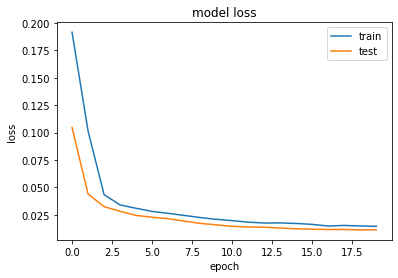

In [218]:
# summarize history for loss
import matplotlib.pyplot as plt
plt.plot(model_summary.history['loss'])
plt.plot(model_summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [219]:
model1 = load_model('model1/')

In [220]:
train_predicted = model1.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

In [221]:
def test_result(model,scaler,test_input,test_target):
  test_predictions = model1.predict(test_input).flatten()
  shape = (test_predictions.shape[0],1)
  test_predicted = scaler.inverse_transform(np.concatenate((test_predictions.reshape(-1,1),np.ones(shape),np.ones(shape)),axis=1))[:,0]
  test_target = scaler.inverse_transform(np.concatenate((test_target.reshape(-1,1),np.ones(shape),np.ones(shape)),axis=1))[:,0]
  test_results = pd.DataFrame(data={'test_predicted':test_predicted, 'test_target':test_target})
  return test_results,explained_variance_score(test_target,test_predictions),mean_squared_error(test_target,test_predictions),mean_absolute_percentage_error(test_target,test_predictions)


In [222]:
test_results,R2_score,MSE,MAPE = test_result(model,scaler,test_input,test_target)

In [224]:
R2_score,MSE,MAPE

(0.25632633358155343, 109.77954165743985, 0.9636348065481574)

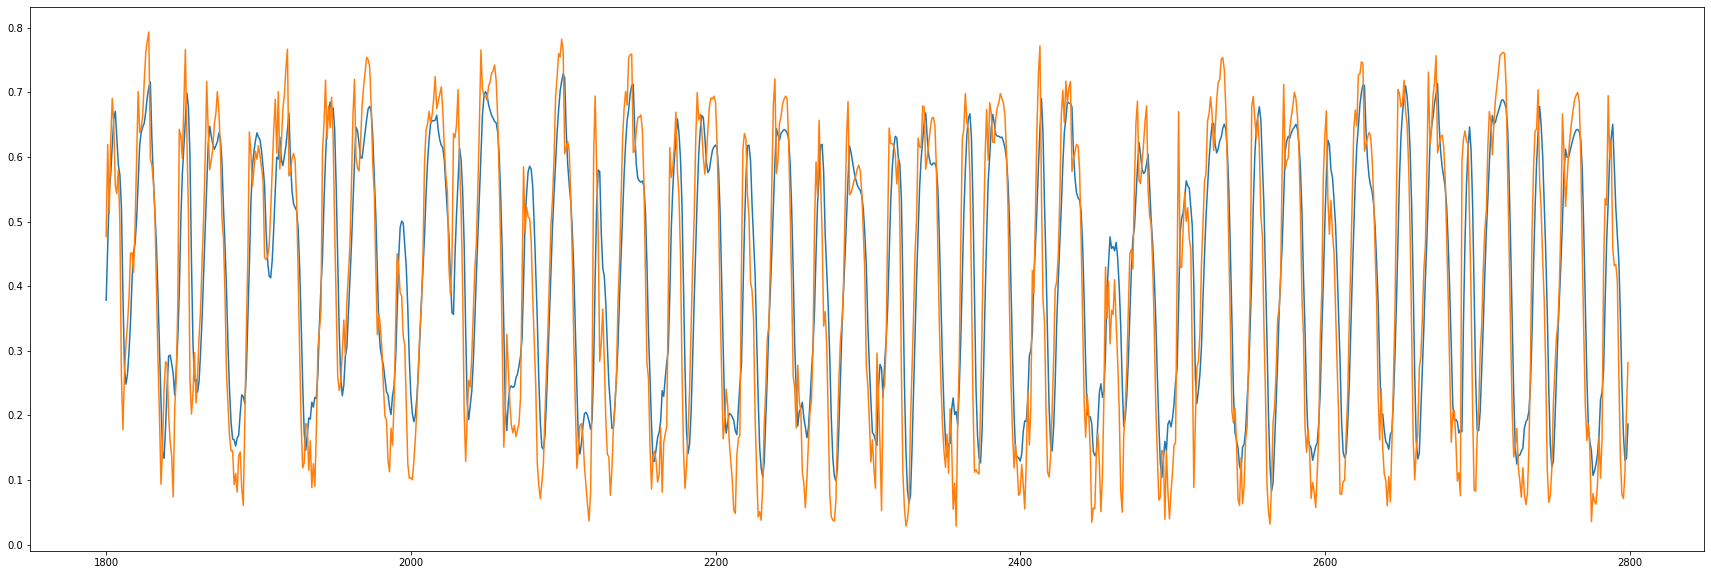

In [223]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(train_results['train_predicted'][1800:2800])
plt.plot(train_results['train_target'][1800:2800])

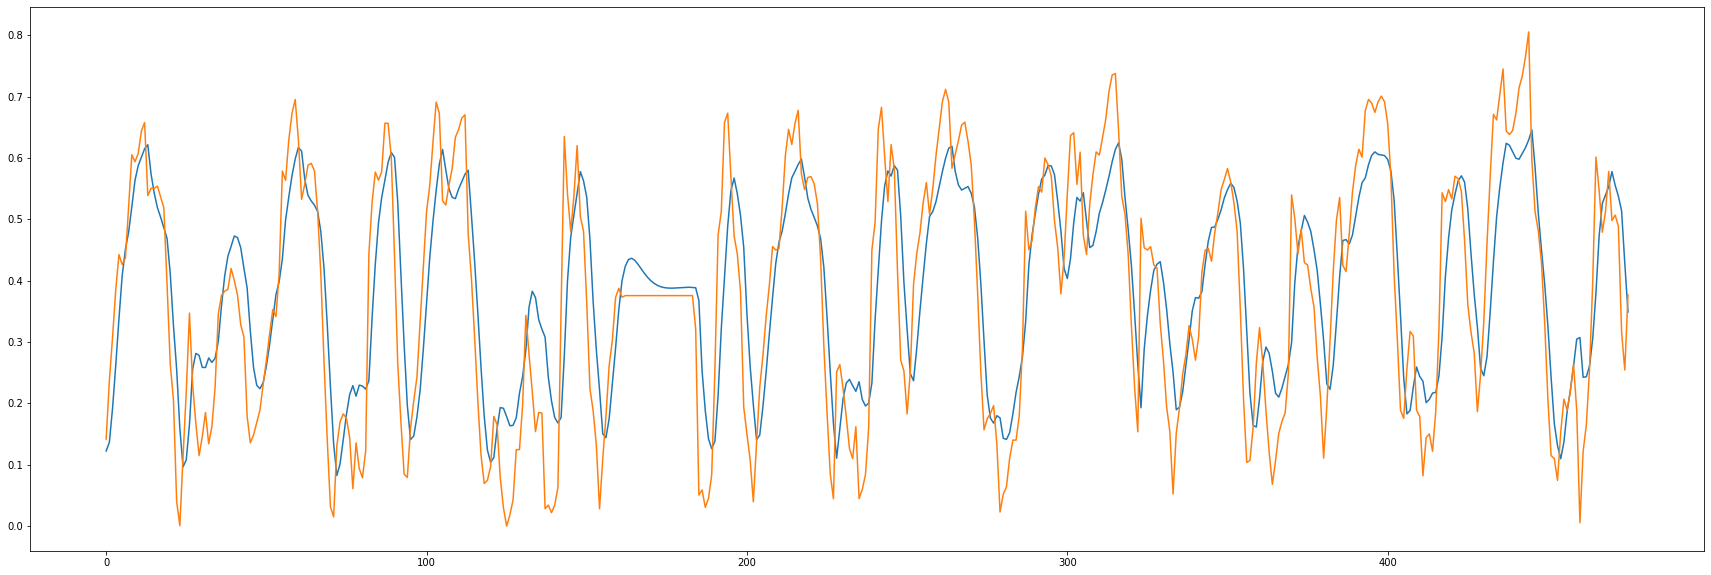

In [204]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(test_results['test_predicted'][50:1500])
plt.plot(test_results['test_target'][50:1500])

**MODEL2..Conv1D**

In [70]:
def create_model():
  model2 = Sequential()
  model2.add(InputLayer((n_lags, len(cols))))
  model2.add(Conv1D(64, kernel_size=2))
  model2.add(Flatten())
  model2.add(Dense(8, 'relu'))
  model2.add(Dense(1, 'linear'))

  model2.summary()
  return model2

In [79]:
model = create_model()
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model.fit(train_input, train_target, validation_data=(test_input, test_target), epochs=20, callbacks=[cp2])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 119, 64)           448       
                                                                 
 flatten_1 (Flatten)         (None, 7616)              0         
                                                                 
 dense_4 (Dense)             (None, 8)                 60936     
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 61,393
Trainable params: 61,393
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
719/719 [==============================] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.1042INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


719/719 [==============================] - 5s 7ms/step - loss: 0.0109 - root_mean_squared_error: 0.1042 - val_loss: 1.3975 - val_root_mean_squared_error: 1.1822
Epoch 2/20
719/719 [==============================] - 4s 6ms/step - loss: 0.0086 - root_mean_squared_error: 0.0927 - val_loss: 1.4066 - val_root_mean_squared_error: 1.1860
Epoch 3/20
719/719 [==============================] - 4s 6ms/step - loss: 0.0084 - root_mean_squared_error: 0.0915 - val_loss: 1.4077 - val_root_mean_squared_error: 1.1865
Epoch 4/20
717/719 [============================>.] - ETA: 0s - loss: 0.0083 - root_mean_squared_error: 0.0912INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


719/719 [==============================] - 5s 7ms/step - loss: 0.0083 - root_mean_squared_error: 0.0913 - val_loss: 1.3765 - val_root_mean_squared_error: 1.1733
Epoch 5/20
719/719 [==============================] - 4s 6ms/step - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 1.4124 - val_root_mean_squared_error: 1.1884
Epoch 6/20
710/719 [============================>.] - ETA: 0s - loss: 0.0083 - root_mean_squared_error: 0.0910INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


719/719 [==============================] - 7s 10ms/step - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 1.3737 - val_root_mean_squared_error: 1.1721
Epoch 7/20
719/719 [==============================] - 4s 6ms/step - loss: 0.0082 - root_mean_squared_error: 0.0903 - val_loss: 1.3943 - val_root_mean_squared_error: 1.1808
Epoch 8/20
719/719 [==============================] - 4s 6ms/step - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 1.3809 - val_root_mean_squared_error: 1.1751
Epoch 9/20
717/719 [============================>.] - ETA: 0s - loss: 0.0080 - root_mean_squared_error: 0.0894INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


719/719 [==============================] - 5s 7ms/step - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 1.3659 - val_root_mean_squared_error: 1.1687
Epoch 10/20
719/719 [==============================] - 4s 6ms/step - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 1.3718 - val_root_mean_squared_error: 1.1713
Epoch 11/20
719/719 [==============================] - 4s 6ms/step - loss: 0.0078 - root_mean_squared_error: 0.0885 - val_loss: 1.3843 - val_root_mean_squared_error: 1.1766
Epoch 12/20
719/719 [==============================] - 4s 6ms/step - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 1.3942 - val_root_mean_squared_error: 1.1807
Epoch 13/20
719/719 [==============================] - 5s 6ms/step - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 1.3881 - val_root_mean_squared_error: 1.1782
Epoch 14/20
712/719 [============================>.] - ETA: 0s - loss: 0.0076 - root_mean_squared_error: 0.0873INFO:tensorflow:Assets written to: m

INFO:tensorflow:Assets written to: model2/assets


719/719 [==============================] - 5s 7ms/step - loss: 0.0076 - root_mean_squared_error: 0.0873 - val_loss: 1.3644 - val_root_mean_squared_error: 1.1681
Epoch 15/20
719/719 [==============================] - 4s 6ms/step - loss: 0.0076 - root_mean_squared_error: 0.0870 - val_loss: 1.4087 - val_root_mean_squared_error: 1.1869
Epoch 16/20
719/719 [==============================] - 4s 6ms/step - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 1.3846 - val_root_mean_squared_error: 1.1767
Epoch 17/20
719/719 [==============================] - 4s 6ms/step - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 1.3827 - val_root_mean_squared_error: 1.1759
Epoch 18/20
719/719 [==============================] - 4s 6ms/step - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 1.4005 - val_root_mean_squared_error: 1.1834
Epoch 19/20
719/719 [==============================] - 4s 6ms/step - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 1.3923 - val_root_m

In [80]:
from tensorflow.keras.models import load_model
model2 = load_model('model2/')

In [81]:
train_predicted = model2.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

In [82]:
test_results,mae = test_result(model2,scaler,test_input,test_target)
mae

0.7995637702213991

**Model3...GRU**

In [ ]:
model3 = Sequential()
model3.add(InputLayer((n_lags, len(cols))))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

In [ ]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
model3.fit(train_input, train_target, validation_data=(validation_input, validation_target), epochs=10, callbacks=[cp3])

In [ ]:
from tensorflow.keras.models import load_model
model3 = load_model('model3/')

In [ ]:
train_predicted = model2.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

test_predictions = model2.predict(test_input).flatten()
test_results = pd.DataFrame(data={'test_predictions':test_predictions, 'test_target':test_target.flatten()})

In [ ]:
print(f"Test error...")
mean_squared_error(test_results.test_predictions,test_results.test_target)

In [ ]:
print(f"Training Error....")
mean_squared_error(train_results.train_predicted,train_results.train_target)